# Mount Google Drive

In [20]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Install external libraries

In [21]:
!pip install albumentations==0.4.6
!pip install torch
!pip install torchvision

# Imports

In [22]:
import os
import matplotlib.pyplot as plt
from cv2 import imread, cvtColor, COLOR_BGR2RGB, COLOR_BGR2GRAY
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch 
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
import time
import copy

# Constants

In [23]:
BASE_DIR = 'gdrive/MyDrive/datasets/Deep_BlueBerry_databases/instancesegmentation'

IMAGES_DIR = BASE_DIR + '/images/'
MASKS_DIR = BASE_DIR + '/masks/'
TEST_DIR = BASE_DIR + '/test'

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

# Dataset

In [25]:
train_transform = A.Compose(
    [
     A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5),
     A.Rotate(),
     A.GaussNoise(),
     A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    ],
    additional_targets={
      'image' : 'image',
      'mask'  : 'image',
    }
)

test_transform = A.Compose(
    [
     A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH)
    ]
)

to_grayscale = A.Compose(
    [
      ToTensorV2()
    ]
)


class BlueberryDataset(Dataset):
    def __init__(self, base_path, image_path, mask_path, transform=None):
        self.images = []
        self.masks = []
        self.transform = transform
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
        self.process_mask = transforms.Compose(
            [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            ]
        )
    
        for image_file in os.listdir(image_path):
            self.images.append(os.path.join(image_path, image_file))
            mask_file = image_file[-12:-3] + 'png'
            self.masks.append(os.path.join(mask_path, mask_file))
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index): 
        image = imread(self.images[index])
        image = cvtColor(image, COLOR_BGR2RGB)
        
        mask = imread(self.masks[index])
        mask = cvtColor(mask, COLOR_BGR2RGB)
        
        transformed = self.transform(image=image, mask=mask)
        
        image = transformed['image']
        mask = transformed['mask']
        
        image = self.to_tensor(image) 
        mask = Image.fromarray(mask)
        mask = self.process_mask(mask)
        
        return image, mask
    
class BlueberryTestDataset(Dataset):
    def __init__(self, base_path, image_path, transform=None):
        self.images = []
        self.transform = transform
        self.to_tensor = transforms.Compose([transforms.ToTensor()])
    
        for image_file in os.listdir(image_path):
            self.images.append(os.path.join(image_path, image_file))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = imread(self.images[index])
        image = cvtColor(image, COLOR_BGR2RGB)
        transformed = self.transform(image=image)
    
        image = transformed['image']
        image = self.to_tensor(image)
    
        return image

dataset = BlueberryDataset(BASE_DIR, IMAGES_DIR, MASKS_DIR, transform=train_transform) 
train_set, val_set = torch.utils.data.random_split(dataset, [6, 1])

test = BlueberryTestDataset(BASE_DIR, TEST_DIR, test_transform)

dataloaders = {
    'train': DataLoader(train_set, batch_size=1, shuffle=True),
    'val': DataLoader(val_set, batch_size=1, shuffle=True),
    'test': DataLoader(test, batch_size=1, shuffle=True)
}


# Visualize Data

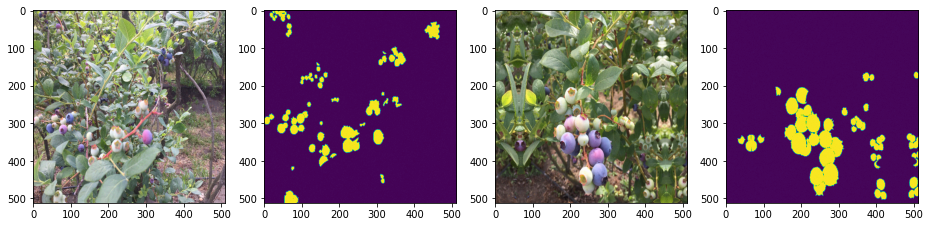

In [26]:
image1, mask1 = dataset[0]
image2, mask2 = dataset[2]

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 5, 1)
ax1.imshow(image1.permute(1, 2, 0))
ax2 = fig.add_subplot(2, 5, 2)
ax2.imshow(mask1.permute(1, 2, 0).squeeze(2))

ax3 = fig.add_subplot(2, 5, 3)
ax3.imshow(image2.permute(1, 2, 0))
ax4 = fig.add_subplot(2, 5, 4)
ax4.imshow(mask2.permute(1, 2, 0).squeeze(2))

plt.show()

# Build model

In [27]:
# Source: https://github.com/usuyama/pytorch-unet
from torch import nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

unet = ResNetUNet(n_class=3)

# Model summary

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=1)
model = model.to(device)

from torchsummary import summary
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 256, 256]           9,408
            Conv2d-6         [-1, 64, 256, 256]           9,408
       BatchNorm2d-7         [-1, 64, 256, 256]             128
       BatchNorm2d-8         [-1, 64, 256, 256]             128
              ReLU-9         [-1, 64, 256, 256]               0
             ReLU-10         [-1, 64, 256, 256]               0
        MaxPool2d-11         [-1, 64, 128, 128]               0
        MaxPool2d-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]          36,864
           Conv2d-14         [-1, 64, 1

# Define training functions

In [29]:
# Source: https://github.com/usuyama/pytorch-unet

from collections import defaultdict
import torch.nn.functional as F


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    training_loss_array = []
    validation_loss_array = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                validation_loss_array.append(epoch_loss)
            else:
                training_loss_array.append(epoch_loss)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))
    print('\n\n')
    plt.plot(range(len(training_loss_array)), training_loss_array, label='training')
    plt.plot(range(len(validation_loss_array)), validation_loss_array, label='validation')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train

cuda:0
Epoch 0/19
----------
LR 0.0001


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.675395, dice: 0.771073, loss: 0.723234
val: bce: 0.531263, dice: 0.823182, loss: 0.677222
saving best model
0m 9s
Epoch 1/19
----------
LR 0.0001
train: bce: 0.382885, dice: 0.775097, loss: 0.578991
val: bce: 0.442128, dice: 0.862890, loss: 0.652509
saving best model
0m 8s
Epoch 2/19
----------
LR 0.0001
train: bce: 0.311996, dice: 0.676757, loss: 0.494376
val: bce: 0.391941, dice: 0.791244, loss: 0.591593
saving best model
0m 8s
Epoch 3/19
----------
LR 0.0001
train: bce: 0.271851, dice: 0.603997, loss: 0.437924
val: bce: 0.327326, dice: 0.621443, loss: 0.474384
saving best model
0m 10s
Epoch 4/19
----------
LR 0.0001
train: bce: 0.264788, dice: 0.566869, loss: 0.415828
val: bce: 0.298122, dice: 0.552996, loss: 0.425559
saving best model
0m 7s
Epoch 5/19
----------
LR 0.0001
train: bce: 0.251351, dice: 0.531245, loss: 0.391298
val: bce: 0.229715, dice: 0.530209, loss: 0.379962
saving best model
0m 7s
Epoch 6/19
----------
LR 0.0001
train: bce: 0.262067, dice: 0.530582, l

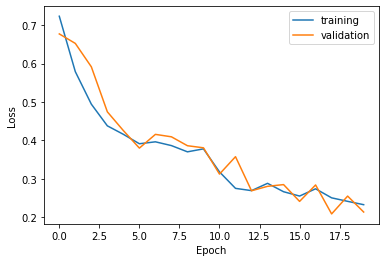

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1
model = ResNetUNet(num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

# Prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


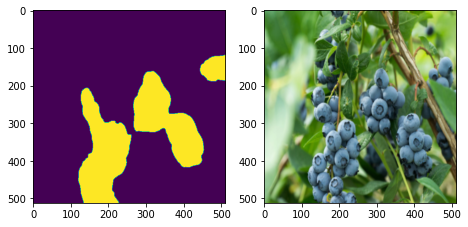

In [31]:
import math
import numpy as np

model.eval()

# Get the first batch
inputs = next(iter(dataloaders['test']))
inputs = inputs.to(device)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()

prediction_image = pred[0][0]
prediction_image[prediction_image >= 0.5] = 1
prediction_image[prediction_image < 0.5] = 0

original_image = inputs.cpu()[0] 
original_image = original_image.permute(1, 2, 0) # Rearrange RGB in the correct order

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 5, 1)
ax1.imshow(prediction_image)
ax2 = fig.add_subplot(2, 5, 2)
ax2.imshow(original_image)

plt.show()
